In [ ]:
from math import log, sqrt, exp
from statistics import NormalDist

class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot / strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        put_price = strike * NormalDist().cdf(-d2) - spot * NormalDist().cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        return NormalDist().cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        return NormalDist().pdf(d1) / (spot * volatility * sqrt(time_to_expiry))

    @staticmethod
    def vega(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        return NormalDist().pdf(d1) * (spot * sqrt(time_to_expiry)) / 100

    @staticmethod
    def implied_volatility(call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        # binary search ts
        for _ in range(max_iterations):
            estimated_price = BlackScholes.black_scholes_call(spot, strike, time_to_expiry, volatility)
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [32]:
import pandas as pd

# read data into dataframe
df = pd.concat([
    pd.read_csv(f'data/prices_round_3_day_0.csv', sep=';'),
    pd.read_csv(f'data/prices_round_3_day_1.csv', sep=';'),
    pd.read_csv(f'data/prices_round_3_day_2.csv', sep=';')
], ignore_index=True)

df['timestamp'] += df['day'] * 1_000_000

# drop unnecessary columns
df.drop(columns=[
    'day', 'bid_price_1', 'bid_volume_1', 'bid_price_2',
    'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1',
    'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3',
    'ask_volume_3', 'profit_and_loss'
], inplace=True)

spot_prices = df[df['product'] == 'VOLCANIC_ROCK'][['timestamp', 'mid_price']].rename(columns={'mid_price': 'spot_price'})

voucher_dfs = {
    9500: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'], spot_prices, on='timestamp', how='left'),
    9750: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'], spot_prices, on='timestamp', how='left'),
    10000: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'], spot_prices, on='timestamp', how='left'),
    10250: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'], spot_prices, on='timestamp', how='left'),
    10500: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'], spot_prices, on='timestamp', how='left')
}

In [33]:
# use BlackScholes model to calculate implied volatility for each voucher
for strike_price, voucher_df in voucher_dfs.items():
    voucher_df['time_to_expiry'] = (5/7) - (voucher_df['timestamp'] / 1000000) / 7 # round 3: option expires in 7 - 2 days

    # calculate implied volatility using Black-Scholes model
    voucher_df['implied_volatility'] = voucher_df.apply(
        lambda row: BlackScholes.implied_volatility(row['mid_price'], row['spot_price'], strike_price, row['time_to_expiry']), axis=1
    )
    
    # calcuate delta
    voucher_df['delta'] = voucher_df.apply(
        lambda row: BlackScholes.delta(row['spot_price'], strike_price, row['time_to_expiry'], row['implied_volatility']), axis=1
    )
    
    # calcuate gamma
    voucher_df['gamma'] = voucher_df.apply(
        lambda row: BlackScholes.gamma(row['spot_price'], strike_price, row['time_to_expiry'], row['implied_volatility']), axis=1
    )

    # calcuate vega
    voucher_df['vega'] = voucher_df.apply(
        lambda row: BlackScholes.vega(row['spot_price'], strike_price, row['time_to_expiry'], row['implied_volatility']), axis=1
    )
    
    voucher_dfs[strike_price] = voucher_df

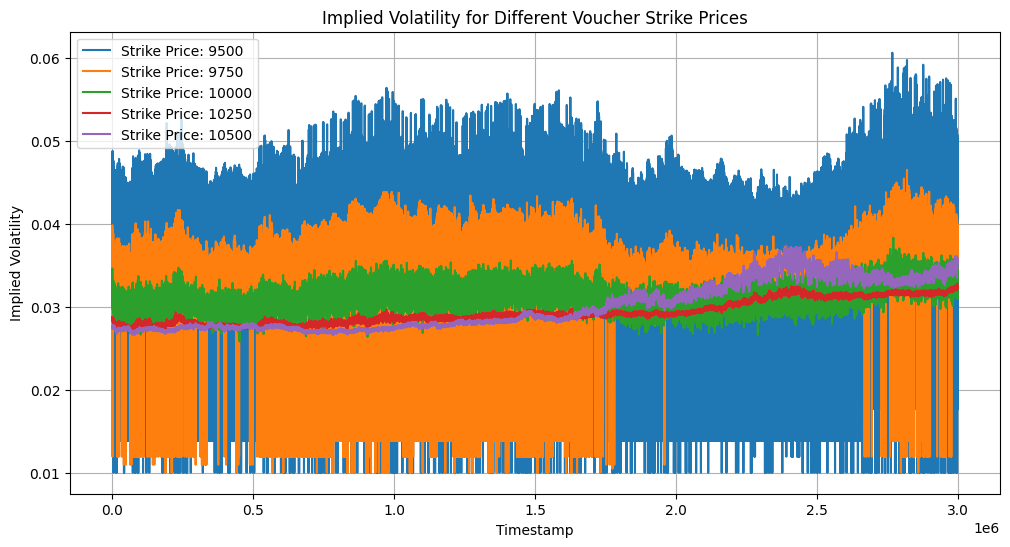

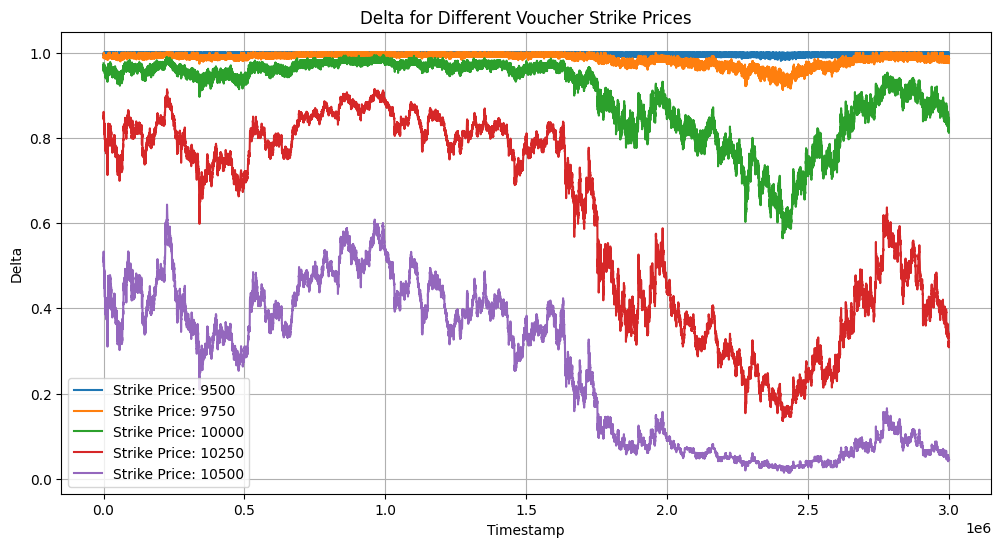

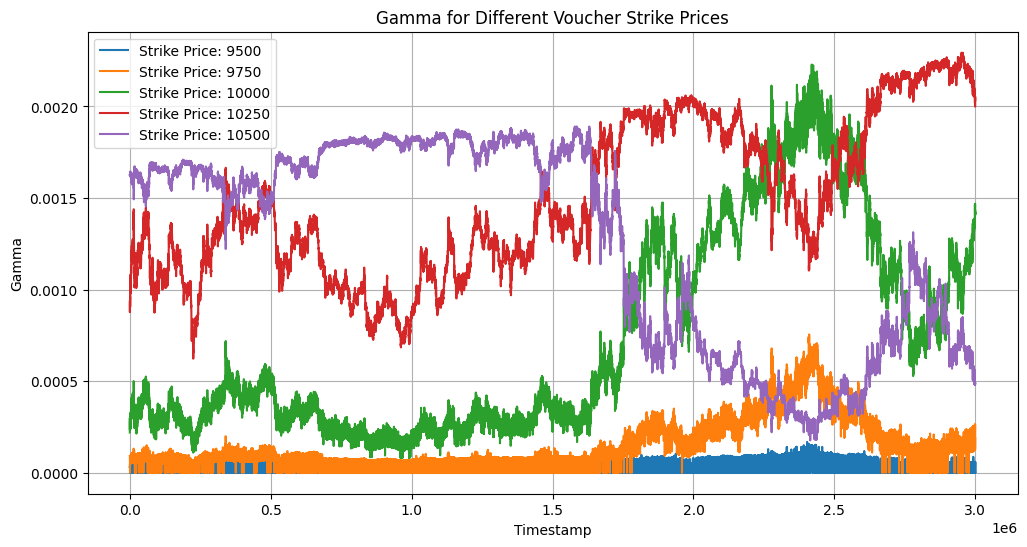

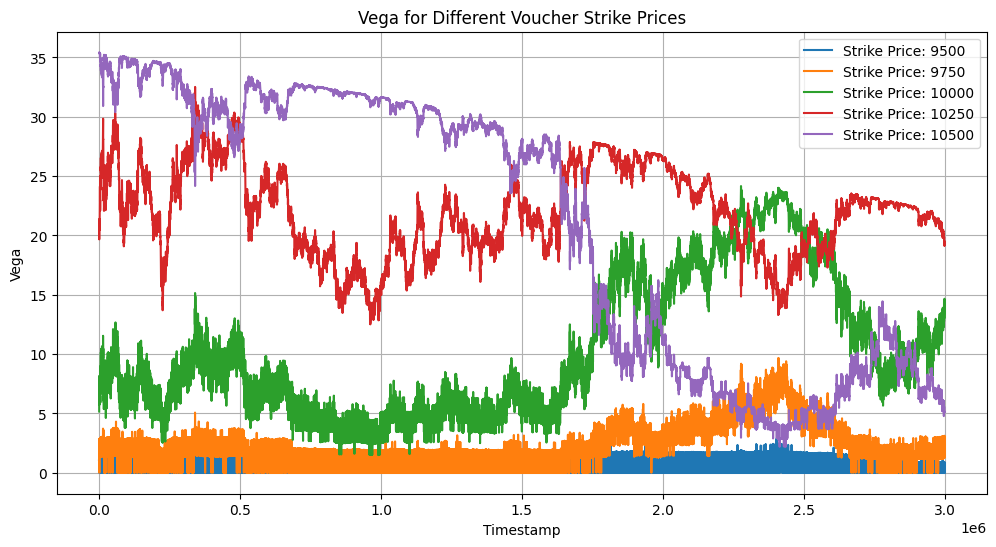

In [35]:
# plot the implied volatility for each voucher
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title("Implied Volatility for Different Voucher Strike Prices")
for strike_price, voucher_df in voucher_dfs.items():
    plt.plot(voucher_df['timestamp'], voucher_df['implied_volatility'], label=f'Strike Price: {strike_price}')
plt.xlabel("Timestamp")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid()
plt.savefig('results/iv.png')
plt.show()

# plot the delta for each voucher
plt.figure(figsize=(12, 6))
plt.title("Delta for Different Voucher Strike Prices")
for strike_price, voucher_df in voucher_dfs.items():
    plt.plot(voucher_df['timestamp'], voucher_df['delta'], label=f'Strike Price: {strike_price}')
plt.xlabel("Timestamp")
plt.ylabel("Delta")
plt.legend()
plt.grid()
plt.savefig('results/delta.png')
plt.show()

# plot the gamma for each voucher
plt.figure(figsize=(12, 6))
plt.title("Gamma for Different Voucher Strike Prices")
for strike_price, voucher_df in voucher_dfs.items():
    plt.plot(voucher_df['timestamp'], voucher_df['gamma'], label=f'Strike Price: {strike_price}')
plt.xlabel("Timestamp")
plt.ylabel("Gamma")
plt.legend()
plt.grid()
plt.savefig('results/gamma.png')
plt.show()

# plot the vega for each voucher
plt.figure(figsize=(12, 6))
plt.title("Vega for Different Voucher Strike Prices")
for strike_price, voucher_df in voucher_dfs.items():
    plt.plot(voucher_df['timestamp'], voucher_df['vega'], label=f'Strike Price: {strike_price}')
plt.xlabel("Timestamp")
plt.ylabel("Vega")
plt.legend()
plt.grid()
plt.savefig('results/vega.png')
plt.show()

In [36]:
# get mean volatility for each voucher
mean_vols = {strike_price: voucher_df['implied_volatility'].mean() for strike_price, voucher_df in voucher_dfs.items()}
print("Mean Implied Volatility for Each Voucher Strike Price:")
for strike_price, mean_vol in mean_vols.items():
    print(f"Strike Price {strike_price}: {mean_vol}")

Mean Implied Volatility for Each Voucher Strike Price:
Strike Price 9500: 0.03336990208786825
Strike Price 9750: 0.0344296202495087
Strike Price 10000: 0.03129081943938605
Strike Price 10250: 0.029347176353511733
Strike Price 10500: 0.03001790981783722
